# Importação do dataset

In [1]:
import pandas as pd

df = pd.read_csv('campeonato-brasileiro-full.csv', delimiter=',')


# Tratamento dos dados

## Criação de algumas classes para modelar os dados
Nas seções de código seguintes, foram criadas algumas classes para modelar os dados referentes a **Times**, **Rodadas** e **Campeonatos**. As classes foram criadas para as consultas posteriores necessárias para a construção dos gráficos.

In [2]:
class Team:
  def __init__(self, name):
    self.name=name
    # self.points=0
    
    self.goals_difference_home=0
    self.goals_difference_guest=0
    self.goals_for_home=0
    self.goals_for_guest=0
    self.goals_against_home=0
    self.goals_against_guest=0

    self.won_home=0
    self.won_guest=0
    self.lost_home=0
    self.lost_guest=0
    self.drawn_home=0
    self.drawn_guest=0

  def record(self):
    return (100.0*self.points())/(self.matches_played()*3)
  
  def record_home(self):
    return (100*self.points_home())/(self.matches_played_home()*3)
  
  def record_guest(self):
    return (100*self.points_guest())/(self.matches_played_guest()*3)
  
  def matches_played(self):
    return self.matches_played_home() + self.matches_played_guest()

  def matches_played_home(self):
    return self.won_home + self.drawn_home + self.lost_home
  
  def matches_played_guest(self):
    return self.won_guest + self.drawn_guest + self.lost_guest

  def won(self):
    return self.won_home + self.won_guest
  
  def drawn(self):
    return self.drawn_home + self.drawn_guest
  
  def lost(self):
    return self.lost_home + self.lost_guest
  
  def points_home(self):
    return 3*self.won_home + self.drawn_home
  
  def points_guest(self):
    return 3*self.won_guest + self.drawn_guest
  
  def points(self):
    return self.points_home() + self.points_guest()
  
  def goals_for(self):
    return self.goals_for_home + self.goals_for_guest
  
  def goals_against(self):
    return self.goals_against_home + self.goals_against_guest
  
  def goals_difference(self):
    return self.goals_for() - self.goals_against()
  
  def compute_game_home(self, goals_for, goals_against):
    self.goals_for_home += goals_for
    self.goals_against_home += goals_against

    if(goals_for > goals_against):
      self.won_home+=1
    elif(goals_for == goals_against):
      self.drawn_home+=1
    else:
      self.lost_home+=1
  
  def compute_game_guest(self, goals_for, goals_against):
    self.goals_for_guest += goals_for
    self.goals_against_guest += goals_against

    if(goals_for > goals_against):
      self.won_guest+=1
    elif(goals_for == goals_against):
      self.drawn_guest+=1
    else:
      self.lost_guest+=1

In [3]:
class Round:
  def __init__(self, number):
    self.number = number
    self.teams = []
    self.goals_home=0
    self.goals_guest=0
  
  def sorted_teams(self):
    return sorted(self.teams, key=lambda team: (team.points(), team.won(), team.goals_difference()), reverse=True)

  def goals_average(self):
    return (self.goals()*2)/len(self.teams)

  def goals(self):
    return self.goals_home + self.goals_guest
  
  def goals_average_home(self):
    return (self.goals_home*2)/len(self.teams)
  
  def goals_average_guest(self):
    return (self.goals_guest*2)/len(self.teams)

  def max_hounds(self):
    return 2*(len(self.teams)-1)

  def champion(self):
    remaining_rounds = self.max_hounds() - self.number
    table = self.sorted_teams()

    first = table[0]
    second = table[1]

    if(first.points() - second.points() > 3*remaining_rounds):
      return first
    
    if(first.points() - second.points() == 3*remaining_rounds):
      if(first.won() > second.won() + remaining_rounds):
        return first
    
    return None
  
  def compute_game(self, home, guest, goals_home, goals_guest):
    self.goals_home += goals_home
    self.goals_guest += goals_guest

    index_home = self.get_team_index(home)
    index_guest = self.get_team_index(guest)

    if(index_home == -1):
      index_home = len(self.teams)
      self.teams.append(Team(home))
    
    if(index_guest == -1):
      index_guest = len(self.teams)
      self.teams.append(Team(guest))

    self.teams[index_home].compute_game_home(goals_home, goals_guest)
    self.teams[index_guest].compute_game_guest(goals_guest, goals_home)

  def get_team_index(self, team_name):
    for index in range(len(self.teams)):
      if(self.teams[index].name == team_name):
        return index
    
    return -1
  
  def average_record_home(self):
    result=0
    for team in self.teams:
      result += team.record_home()
    return result/len(self.teams)
  
  def average_record_guest(self):
    result=0
    for team in self.teams:
      result += team.record_guest()
    return result/len(self.teams)

In [4]:
import copy

class Championship:
  def __init__(self, edition):
    self.edition = edition
    self.rounds = []

  def start_new_round(self):
    round_number = len(self.rounds)+1

    if(round_number > 1):
      self.rounds.append(copy.deepcopy(self.rounds[-1]))
      self.rounds[-1].number = round_number
      self.rounds[-1].goals_home = 0
      self.rounds[-1].goals_guest = 0
    else:
      self.rounds.append(Round(round_number))
    
    return self.rounds[-1]
  
  def get_definitive_round(self):
    for round in self.rounds:
      if(round.champion() != None):
        return round
  
  def goals_average(self):
    result = 0
    for round in self.rounds:
      result += round.goals_average()
    return result/len(self.rounds)
  
  def goals_average_home(self):
    result = 0
    for round in self.rounds:
      result += round.goals_average_home()
    return result/len(self.rounds)
  
  def goals_average_guest(self):
    result = 0
    for round in self.rounds:
      result += round.goals_average_guest()
    return result/len(self.rounds)
  
  def average_record_home(self):
    return self.rounds[-1].average_record_home()
  
  def average_record_guest(self):
    return self.rounds[-1].average_record_guest()


# Normalização dos dados
Foram excluidos os dados referentes aos campeonatos até o ano de 2003, onde ainda não era utilizado o sistema de pontos corridos, assim como foram excluidas as partidas do campeonado de 2021, pois a base de dados contém apenas algumas rodadas desta edição.

Além disso, algumas colunas foram renomeadas para facilitar as consultas, e os campos foram normalizados para um formato padronizado.

In [5]:
import io
import pandas as pd

#df = pd.read_csv(io.BytesIO(uploaded['/content/drive/MyDrive/Colab Notebooks/VC/campeonato-brasileiro-full.csv']), delimiter=';')

df['Data']= pd.to_datetime(df['Data'])

df = df.drop(df[(df['ID'] > 8319)].index)
df = df.drop(df[(df['Data'].dt.year < 2003)].index)

years =  df['Data'].dt.year
edicao = years.where(years < 2021, 2020)

df['home'] = df['Mandante'].str.title()
df.drop('Mandante', inplace=True, axis=1)

df['guest'] = df['Visitante'].str.title()
df.drop('Visitante', inplace=True, axis=1)

df['round'] = pd.to_numeric(df['Rodada'])
df.drop('Rodada', inplace=True, axis=1)

df['home_goals'] = pd.to_numeric(df['Mandante Placar'])
df.drop('Mandante Placar', inplace=True, axis=1)

df['guest_goals'] = pd.to_numeric(df['Visitante Placar'])
df.drop('Visitante Placar', inplace=True, axis=1)

df['edition'] = edicao

df = df.sort_values(by=['edition', 'round'])




In [6]:
len(df[(df['edition'] > 2019) & (df['round'] == 10)])


10

## Pre processamento das tabelas
Aqui foi realizado um pre-processamento, computando cada jogo disponibilizado pela base de dados e utilizando as classes previamente criadas, para o estado da tabela em todas as rodadas dos campeonatos analisados.

In [7]:
championships = []
current_edition = -1
current_round = 0

for index, row in df.iterrows():
  edition = row['edition']
  round = row['round']

  if(edition != current_edition):
    championships.append(Championship(edition))
    current_edition = edition

  champ = championships[-1]
  
  if(round != current_round):
    champ.start_new_round()
    current_round = round
  
  champ.rounds[-1].compute_game(row['home'], row['guest'], row['home_goals'], row['guest_goals'])


In [8]:
#definitive = championships[4].get_definitive_round()

print(championships[4].get_definitive_round().champion().points())

73


# Gráficos
Visualizações geradas a partir dos dados modelados.

## Competitividade do campeonato

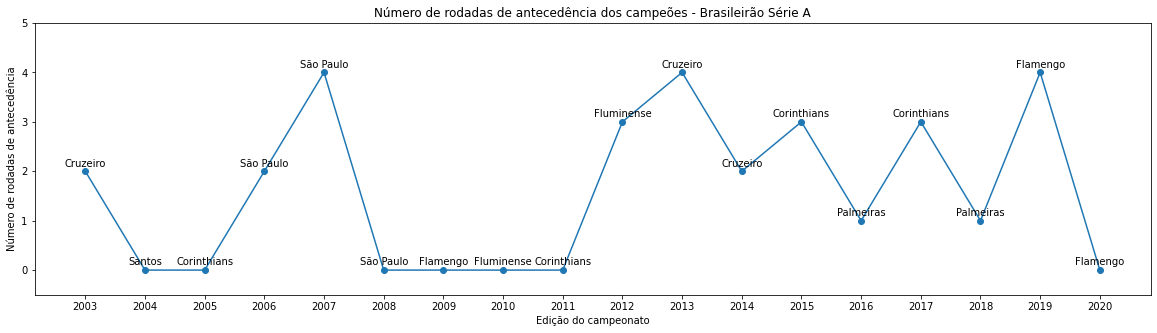

In [9]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]

editions = []
remaining_rounds = []
champions = []

for championship in championships:
  definitive = championship.get_definitive_round()
  champion = definitive.champion()

  editions.append(championship.edition)
  remaining_rounds.append(len(championship.rounds)-definitive.number)
  champions.append(champion.name)

editions = list(map(int, editions))

# fig, ax = plt.subplots()
plt.ylim([-0.5,5])
plt.xticks(editions)
plt.scatter(editions,remaining_rounds)
plt.plot(editions,remaining_rounds)
plt.title("Número de rodadas de antecedência dos campeões - Brasileirão Série A")
plt.xlabel("Edição do campeonato")
plt.ylabel("Número de rodadas de antecedência")

for i,champion in enumerate(champions):
  plt.annotate(champion, (editions[i], remaining_rounds[i]+0.1), ha='center')

plt.show()

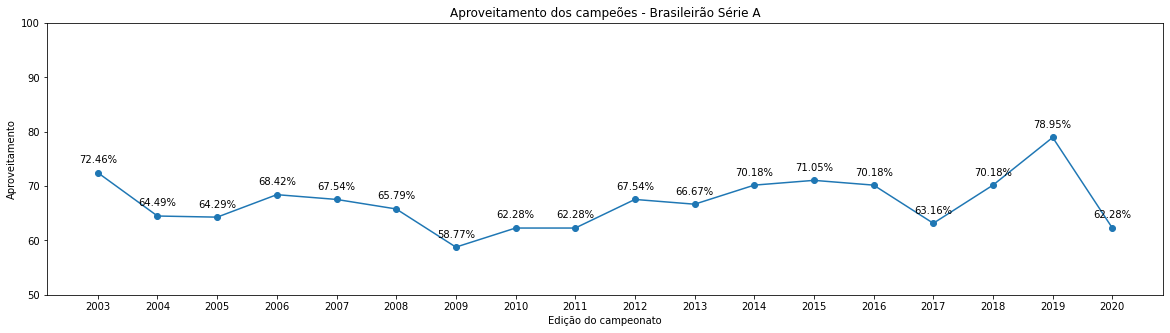

In [10]:
champion_record = []
for championship in championships:
  champion = championship.rounds[-1].champion()

  champion_record.append(champion.record())

plt.rcParams['figure.figsize'] = [20, 5]

plt.ylim([50,100])
plt.xticks(editions)
plt.scatter(editions,champion_record)
plt.plot(editions,champion_record)
plt.title("Aproveitamento dos campeões - Brasileirão Série A")
plt.xlabel("Edição do campeonato")
plt.ylabel("Aproveitamento")

for i,record in enumerate(champion_record):
  plt.annotate(f'{record:.2f}%', (editions[i], champion_record[i]+1.8), ha='center')
plt.show()


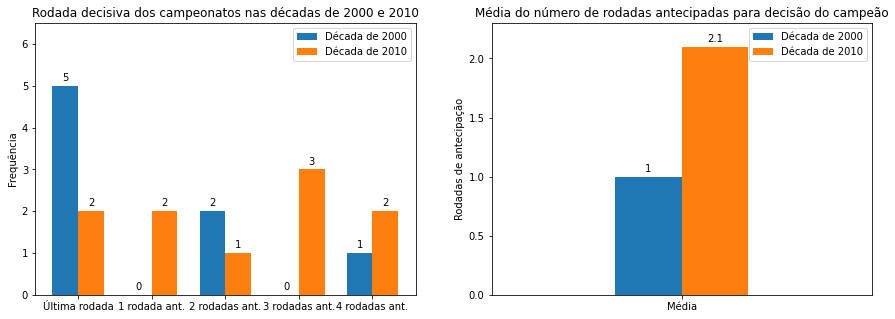

In [11]:
import numpy as np

rounds = list(set(remaining_rounds))
frequency_until2010 = [remaining_rounds[:8].count(x) for x in rounds]
frequency_after2010 = [remaining_rounds[8:].count(x) for x in rounds]
plt.rcParams['figure.figsize'] = [15, 5]


x = np.arange(len(rounds))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1,2)

rects1 = ax1.bar(x-width/2, frequency_until2010, width, label='Década de 2000')
rects2 = ax1.bar(x+width/2, frequency_after2010, width, label='Década de 2010')

ax1.set_ylabel('Frequência')
ax1.set_title('Rodada decisiva dos campeonatos nas décadas de 2000 e 2010')
ax1.set_ylim([0,6.5])

ax1.set_xticks(rounds, ['Última rodada', '1 rodada ant.', '2 rodadas ant.', '3 rodadas ant.', '4 rodadas ant.'])
ax1.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)

def avg(items):
  return sum(items)/len(items)

average_until2010 = avg(remaining_rounds[:8])
average_after2010 = avg(remaining_rounds[8:])
x = np.arange(1)

rects1 = ax2.bar(x-width/2, average_until2010, width, label='Década de 2000')
rects2 = ax2.bar(x+width/2, average_after2010, width, label='Década de 2010')

ax2.set_xlim([-1,1])
ax2.set_ylim([0,2.3])
ax2.set_xticks(x,['Média'])

ax2.set_title('Média do número de rodadas antecipadas para decisão do campeão')
ax2.set_ylabel('Rodadas de antecipação')

ax2.bar_label(rects1, padding=3)
ax2.bar_label(rects2, padding=3)
ax2.legend()


plt.show()

## Média de gols ao longo dos anos

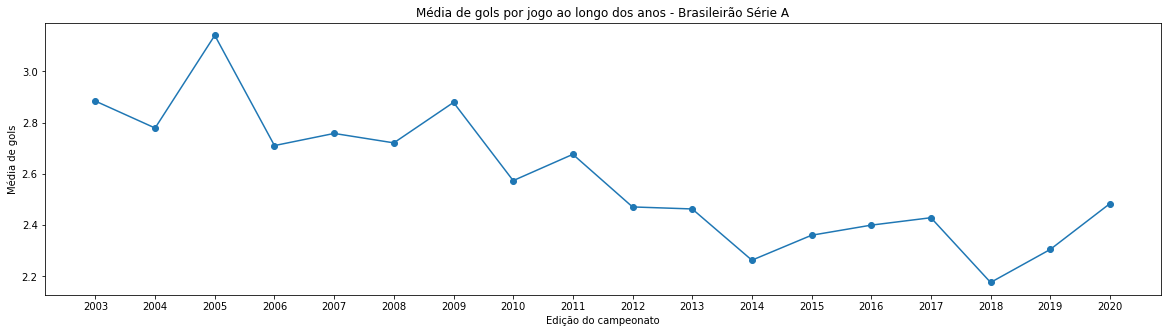

In [12]:
goals_average = [x.goals_average() for x in championships]

plt.rcParams['figure.figsize'] = [20, 5]

plt.xticks(editions)
plt.scatter(editions,goals_average)
plt.plot(editions,goals_average)
plt.title("Média de gols por jogo ao longo dos anos - Brasileirão Série A")
plt.xlabel("Edição do campeonato")
plt.ylabel("Média de gols")

plt.show()

## Diferença entre mandantes e visitantes





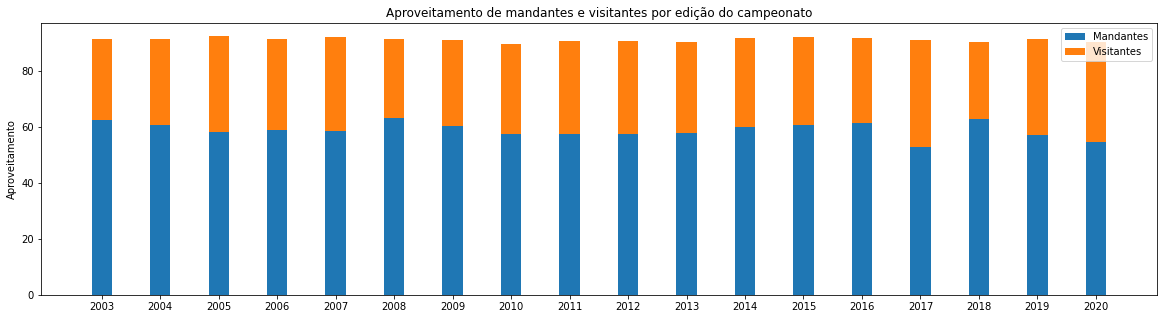

In [13]:
home_means = [x.average_record_home() for x in championships]
guest_means = [x.average_record_guest() for x in championships]

width = 0.35      

fig, ax = plt.subplots()

ax.bar(editions, home_means, width, label='Mandantes')
ax.bar(editions, guest_means, width, bottom=home_means,
       label='Visitantes')

ax.set_ylabel('Aproveitamento')
ax.set_title('Aproveitamento de mandantes e visitantes por edição do campeonato')
ax.set_xticks(editions)
ax.legend()

plt.show()

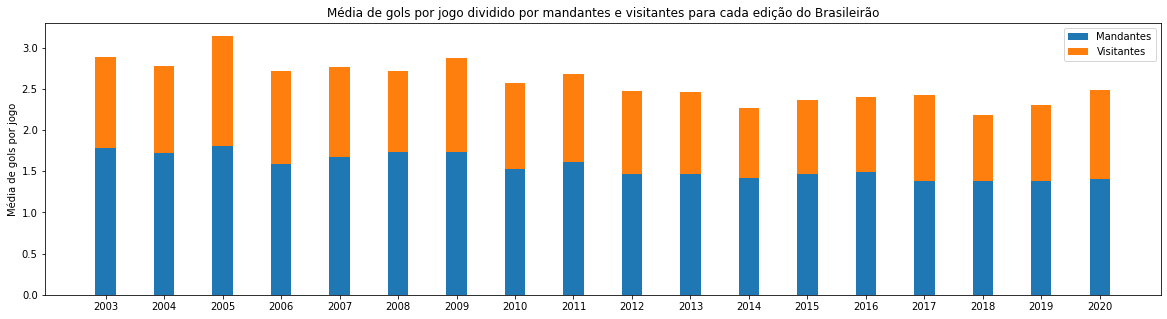

In [14]:
goals_home_means = [x.goals_average_home() for x in championships]
goals_guest_means = [x.goals_average_guest() for x in championships]

width = 0.35      

fig, ax = plt.subplots()

ax.bar(editions, goals_home_means, width, label='Mandantes')
ax.bar(editions, goals_guest_means, width, bottom=goals_home_means,
       label='Visitantes')

ax.set_ylabel('Média de gols por jogo')
ax.set_title('Média de gols por jogo dividido por mandantes e visitantes para cada edição do Brasileirão')
ax.set_xticks(editions)
ax.legend()

plt.show()



## Times

[]

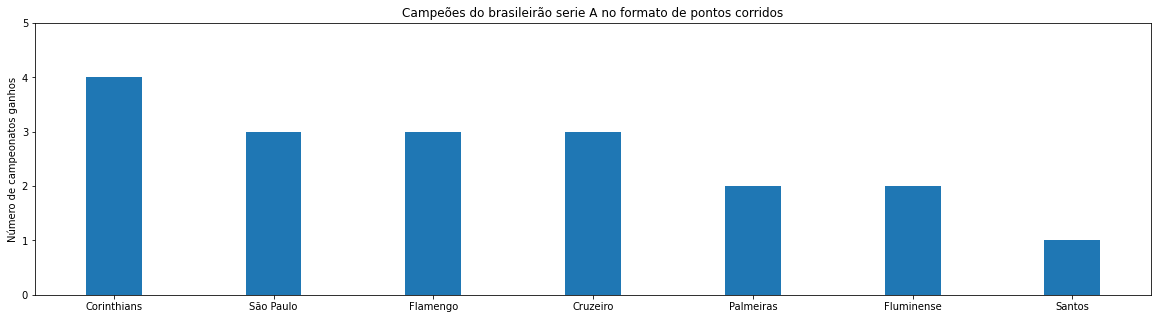

In [15]:
freq_tup = [(champions.count(x),x) for x in list(set(champions))]
freq_tup.sort(reverse=True)
freq, unique_champions = zip(*freq_tup)

x = np.arange(len(unique_champions))

fig, ax = plt.subplots()

rects1 = ax.bar(x, freq, width)

ax.set_ylabel('Número de campeonatos ganhos')
ax.set_title('Campeões do brasileirão serie A no formato de pontos corridos')
ax.set_ylim([0,5])

ax.set_xticks(x, unique_champions)

plt.plot()

In [16]:
class TeamHistory:
  def __init__(self, name):
    self.name = name
    self.points=0
    self.won=0
    self.goals_for=0

teams = {}

for championship in championships:
  last_round = championship.rounds[-1]

  for team in last_round.teams:
    if(not team.name in teams):
      teams[team.name] = TeamHistory(team.name)
    
    teams[team.name].points += team.points()
    teams[team.name].won += team.won()
    teams[team.name].goals_for += team.goals_for()

[]

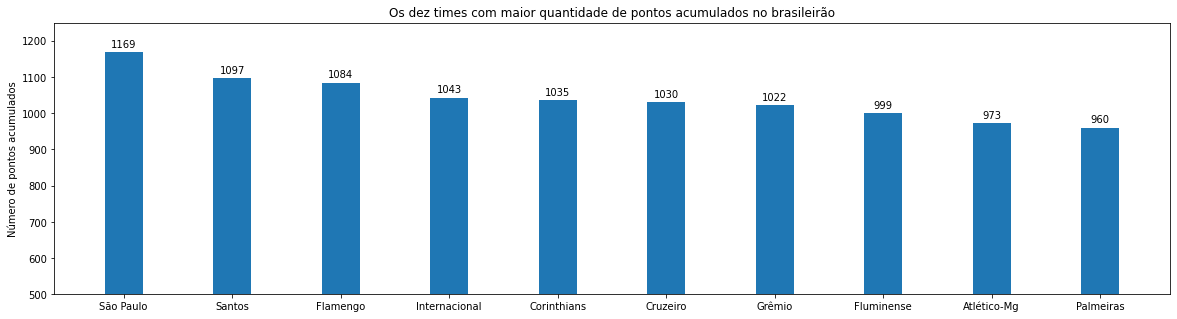

In [17]:
teams_sorted = sorted(teams.values(), key=lambda team:(team.points,team.won),reverse=True)

names = [x.name for x in teams_sorted[:10]]
points = [x.points for x in teams_sorted[:10]]

x = np.arange(len(names))

fig, ax = plt.subplots()

rects1 = ax.bar(names, points, width)

ax.set_ylabel('Número de pontos acumulados')
ax.set_title('Os dez times com maior quantidade de pontos acumulados no brasileirão')
ax.set_ylim([500,1250])

ax.bar_label(rects1, padding=3)

ax.set_xticks(x, names)

plt.plot()

[]

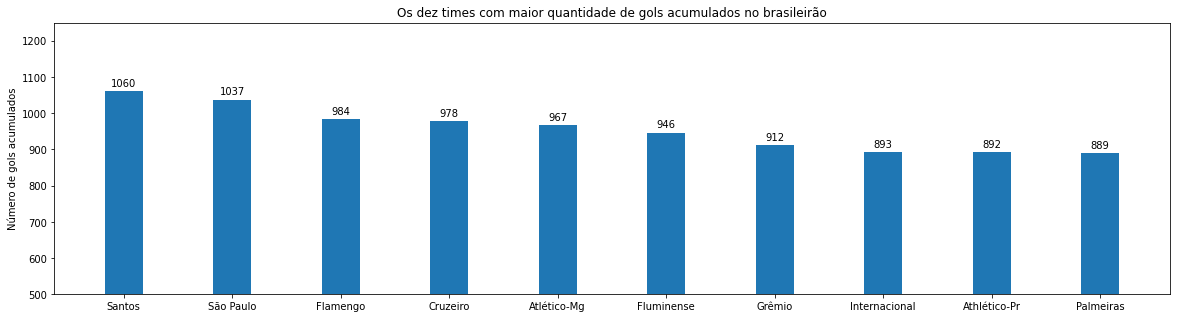

In [18]:
teams_sorted = sorted(teams.values(), key=lambda team:(team.goals_for,team.won),reverse=True)

names = [x.name for x in teams_sorted[:10]]
goals = [x.goals_for for x in teams_sorted[:10]]

x = np.arange(len(names))

fig, ax = plt.subplots()

rects1 = ax.bar(names, goals, width)

ax.set_ylabel('Número de gols acumulados')
ax.set_title('Os dez times com maior quantidade de gols acumulados no brasileirão')
ax.set_ylim([500,1250])

ax.bar_label(rects1, padding=3)

ax.set_xticks(x, names)

plt.plot()

[]

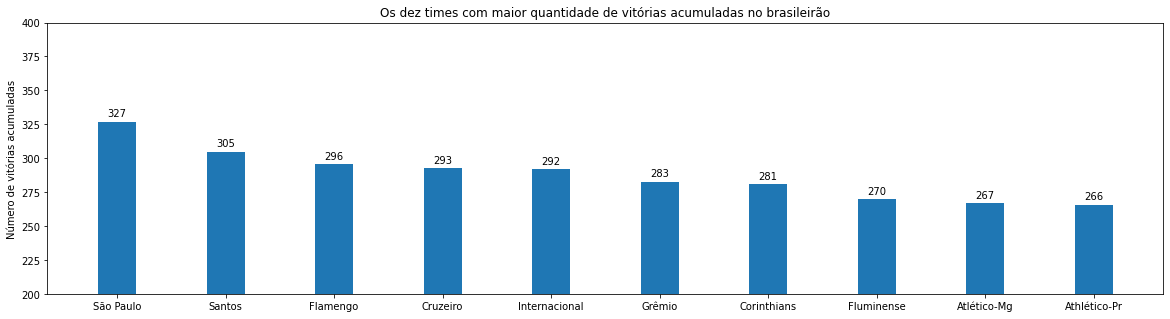

In [19]:
teams_sorted = sorted(teams.values(), key=lambda team:(team.won,team.won),reverse=True)

names = [x.name for x in teams_sorted[:10]]
won = [x.won for x in teams_sorted[:10]]

x = np.arange(len(names))

fig, ax = plt.subplots()

rects1 = ax.bar(names, won, width)

ax.set_ylabel('Número de vitórias acumuladas')
ax.set_title('Os dez times com maior quantidade de vitórias acumuladas no brasileirão')
ax.set_ylim([200,400])

ax.bar_label(rects1, padding=3)

ax.set_xticks(x, names)

plt.plot()